In [10]:
import re
import dash
from dash import html, dcc, Input, Output, State, no_update
import dash_cytoscape as cyto
import numpy as np
from scipy.linalg import block_diag
from collections import defaultdict
from copy import deepcopy
import time

# ==== GBP import ====
from gbp.gbp import *

app = dash.Dash(__name__)
app.title = "Factor Graph SVD Abs&Recovery"


# -----------------------
# SLAM-like base graph
# -----------------------
def make_slam_like_graph(N=100, step_size=25, loop_prob=0.05, loop_radius=50, prior_prop=0.0, seed=None):
    if seed is None :
        rng = np.random.default_rng()  # ✅ Ensure we have an RNG
    else:
        rng = np.random.default_rng(seed)
    nodes, edges = [], []
    positions = []
    x, y = 0.0, 0.0
    positions.append((x, y))

    # ✅ Deterministic-by-RNG: trajectory generation
    for _ in range(1, int(N)):
        dx, dy = rng.standard_normal(2)  # replace np.random.randn
        norm = np.sqrt(dx**2 + dy**2) + 1e-6
        dx, dy = dx / norm * float(step_size), dy / norm * float(step_size)
        x, y = x + dx, y + dy
        positions.append((x, y))

    # Sequential edges along the path
    for i, (px, py) in enumerate(positions):
        nodes.append({
            "data": {"id": f"{i}", "layer": 0, "dim": 2, "num_base": 1},
            "position": {"x": float(px), "y": float(py)}
        })

    for i in range(int(N) - 1):
        edges.append({"data": {"source": f"{i}", "target": f"{i+1}"}})

    # ✅ Deterministic-by-RNG: loop-closure edges
    for i in range(int(N)):
        for j in range(i + 5, int(N)):
            if rng.random() < float(loop_prob):  # replace np.random.rand
                xi, yi = positions[i]
                xj, yj = positions[j]
                if np.hypot(xi - xj, yi - yj) < float(loop_radius):
                    edges.append({"data": {"source": f"{i}", "target": f"{j}"}})

    # ✅ Sample priors using the same RNG
    if prior_prop <= 0.0:
        strong_ids = {0}
    elif prior_prop >= 1.0:
        strong_ids = set(range(N))
    else:
        k = max(1, int(np.floor(prior_prop * N)))
        strong_ids = set(rng.choice(N, size=k, replace=False).tolist())

    # Add edges for nodes with strong priors
    for i in strong_ids:
        edges.append({"data": {"source": f"{i}", "target": "prior"}})

    edges.append({"data": {"source": f"{0}", "target": "anchor"}}) 
    return nodes, edges



# -----------------------
# Grid aggregation
# -----------------------
def fuse_to_super_grid(prev_nodes, prev_edges, gx, gy, layer_idx):
    positions = np.array([[n["position"]["x"], n["position"]["y"]] for n in prev_nodes], dtype=float)
    xmin, ymin = positions.min(axis=0); xmax, ymax = positions.max(axis=0)
    cell_w = (xmax - xmin) / gx if gx > 0 else 1.0
    cell_h = (ymax - ymin) / gy if gy > 0 else 1.0
    if cell_w == 0: cell_w = 1.0
    if cell_h == 0: cell_h = 1.0
    cell_map = {}
    for idx, n in enumerate(prev_nodes):
        x, y = n["position"]["x"], n["position"]["y"]
        cx = min(int((x - xmin) / cell_w), gx - 1)
        cy = min(int((y - ymin) / cell_h), gy - 1)
        cid = cx + cy * gx
        cell_map.setdefault(cid, []).append(idx)
    super_nodes, node_map = [], {}
    for cid, indices in cell_map.items():
        pts = positions[indices]
        mean_x, mean_y = pts.mean(axis=0)
        child_dims = [prev_nodes[i]["data"]["dim"] for i in indices]
        child_nums = [prev_nodes[i]["data"].get("num_base", 1) for i in indices]
        dim_val = int(max(1, sum(child_dims)))
        num_val = int(sum(child_nums))
        nid = str(len(super_nodes))
        super_nodes.append({
            "data": {
                "id": nid,
                "layer": layer_idx,
                "dim": dim_val,
                "num_base": num_val   # Inherit the sum
            },
            "position": {"x": float(mean_x), "y": float(mean_y)}
        })
        for i in indices:
            node_map[prev_nodes[i]["data"]["id"]] = nid
    super_edges, seen = [], set()
    for e in prev_edges:
        u, v = e["data"]["source"], e["data"]["target"]

        if (v != "prior") and (v != "anchor"):
            su, sv = node_map[u], node_map[v]
            if su != sv:
                eid = tuple(sorted((su, sv)))
                if eid not in seen:
                    super_edges.append({"data": {"source": su, "target": sv}})
                    seen.add(eid)
            elif su == sv:
                eid = tuple(sorted((su, "prior")))
                if eid not in seen:
                    super_edges.append({"data": {"source": su, "target": "prior"}})
                    seen.add(eid)

        else:
            su = node_map[u]
            eid = tuple(sorted((su, "prior")))
            if eid not in seen:
                super_edges.append({"data": {"source": su, "target": "prior"}})
                seen.add(eid)

    return super_nodes, super_edges, node_map

# -----------------------
# K-Means aggregation
# -----------------------
def fuse_to_super_kmeans(prev_nodes, prev_edges, k, layer_idx, max_iters=20, tol=1e-6, seed=0):
    positions = np.array([[n["position"]["x"], n["position"]["y"]] for n in prev_nodes], dtype=float)
    n = positions.shape[0]
    if k <= 0: 
        k = 1
    k = min(k, n)
    rng = np.random.default_rng(seed)

    # -------- Improved initialization --------
    # Randomly sample k points without replacement to ensure each cluster starts with a distinct point
    init_idx = rng.choice(n, size=k, replace=False)
    centers = positions[init_idx]

    # Lloyd iterations
    for _ in range(max_iters):
        d2 = ((positions[:, None, :] - centers[None, :, :]) ** 2).sum(axis=2)
        assign = np.argmin(d2, axis=1)

        # -------- Empty-cluster fix --------
        counts = np.bincount(assign, minlength=k)
        empty_clusters = np.where(counts == 0)[0]
        for ci in empty_clusters:
            # Find the largest cluster
            big_cluster = np.argmax(counts)
            big_idxs = np.where(assign == big_cluster)[0]
            # Steal one point over
            steal_idx = big_idxs[0]
            assign[steal_idx] = ci
            counts[big_cluster] -= 1
            counts[ci] += 1

        moved = 0.0
        for ci in range(k):
            idxs = np.where(assign == ci)[0]
            new_c = positions[idxs].mean(axis=0)
            moved = max(moved, float(np.linalg.norm(new_c - centers[ci])))
            centers[ci] = new_c
        if moved < tol:
            break

    # Final assign (redo once to be safe)
    d2 = ((positions[:, None, :] - centers[None, :, :]) ** 2).sum(axis=2)
    assign = np.argmin(d2, axis=1)

    counts = np.bincount(assign, minlength=k)
    empty_clusters = np.where(counts == 0)[0]
    for ci in empty_clusters:
        big_cluster = np.argmax(counts)
        big_idxs = np.where(assign == big_cluster)[0]
        steal_idx = big_idxs[0]
        assign[steal_idx] = ci
        counts[big_cluster] -= 1
        counts[ci] += 1

    # ---------- Build the super graph ----------
    super_nodes, node_map = [], {}
    for ci in range(k):
        idxs = np.where(assign == ci)[0]
        pts = positions[idxs]
        mean_x, mean_y = pts.mean(axis=0)
        child_dims = [prev_nodes[i]["data"]["dim"] for i in idxs]
        child_nums = [prev_nodes[i]["data"].get("num_base", 1) for i in idxs]
        dim_val = int(max(1, sum(child_dims)))
        num_val = int(sum(child_nums)) 
        nid = f"{ci}"
        super_nodes.append({
            "data": {
                "id": nid,
                "layer": layer_idx,
                "dim": dim_val,
                "num_base": num_val   # Inherit the sum
            },
            "position": {"x": float(mean_x), "y": float(mean_y)}
        })
        for i in idxs:
            node_map[prev_nodes[i]["data"]["id"]] = nid

    super_edges, seen = [], set()
    for e in prev_edges:
        u, v = e["data"]["source"], e["data"]["target"]
        if (v != "prior") and (v != "anchor"):
            su, sv = node_map[u], node_map[v]
            if su != sv:
                eid = tuple(sorted((su, sv)))
                if eid not in seen:
                    super_edges.append({"data": {"source": su, "target": sv}})
                    seen.add(eid)
            else:
                eid = (su, "prior")
                if eid not in seen:
                    super_edges.append({"data": {"source": su, "target": "prior"}})
                    seen.add(eid)
        else:
            su = node_map[u]
            eid = (su, "prior")
            if eid not in seen:
                super_edges.append({"data": {"source": su, "target": "prior"}})
                seen.add(eid)

    return super_nodes, super_edges, node_map


def copy_to_abs(super_nodes, super_edges, layer_idx):
    abs_nodes = []
    for n in super_nodes:
        nid = n["data"]["id"].replace("s", "a", 1)
        abs_nodes.append({
            "data": {
                "id": nid,
                "layer": layer_idx,
                "dim": n["data"]["dim"],
                "num_base": n["data"].get("num_base", 1)  # Inherit
            },
            "position": {"x": n["position"]["x"], "y": n["position"]["y"]}
        })
    abs_edges = []
    for e in super_edges:
        abs_edges.append({"data": {
            "source": e["data"]["source"].replace("s", "a", 1),
            "target": e["data"]["target"].replace("s", "a", 1)
        }})
    return abs_nodes, abs_edges

# -----------------------
# Sequential merge (tail group absorbs remainder)
# -----------------------
def fuse_to_super_order(prev_nodes, prev_edges, k, layer_idx, tail_heavy=True):
    """
    Sequentially split prev_nodes in current order into k groups; the last group absorbs the remainder (tail_heavy=True).
    Reuse existing rules for aggregating dim/num_base, deduplicating edges, and propagating prior.
    """
    n = len(prev_nodes)
    if k <= 0: k = 1
    k = min(k, n)

    # Group sizes
    base = n // k
    rem  = n %  k
    if rem > 0:
        sizes = [k]*(base) + [rem]     # Tail absorbs remainder: ..., last += rem
    else:
        sizes = [k]*(base)

    # Build groups: record indices per group
    groups = []
    start = 0
    for s in sizes:
        groups.append(list(range(start, start+s)))
        start += s

    # ---- Build super_nodes & node_map ----
    positions = np.array([[n["position"]["x"], n["position"]["y"]] for n in prev_nodes], dtype=float)

    super_nodes, node_map = [], {}
    for gi, idxs in enumerate(groups):
        pts = positions[idxs]
        mean_x, mean_y = pts.mean(axis=0)

        child_dims = [prev_nodes[i]["data"]["dim"] for i in idxs]
        child_nums = [prev_nodes[i]["data"].get("num_base", 1) for i in idxs]
        dim_val = int(max(1, sum(child_dims)))
        num_val = int(sum(child_nums))

        nid = f"{gi}"  # Same as kmeans: use group index as id (string)
        super_nodes.append({
            "data": {
                "id": nid,
                "layer": layer_idx,
                "dim": dim_val,
                "num_base": num_val
            },
            "position": {"x": float(mean_x), "y": float(mean_y)}
        })
        # Build base-id -> super-id mapping (note: ids are strings throughout)
        for i in idxs:
            node_map[prev_nodes[i]["data"]["id"]] = nid

    # ---- Super edges: keep and deduplicate inter-group edges; intra-group edges collapse to prior; prior edges roll up to their owning super ----
    super_edges, seen = [], set()
    for e in prev_edges:
        u, v = e["data"]["source"], e["data"]["target"]

        if (v != "prior") and (v != "anchor"):
            su, sv = node_map[u], node_map[v]
            if su != sv:
                eid = tuple(sorted((su, sv)))
                if eid not in seen:
                    super_edges.append({"data": {"source": su, "target": sv}})
                    seen.add(eid)
            else:
                # Intra-group pairwise edge → group prior (consistent with grid/kmeans handling)
                eid = tuple(sorted((su, "prior")))
                if eid not in seen:
                    super_edges.append({"data": {"source": su, "target": "prior"}})
                    seen.add(eid)
        else:
            su = node_map[u]
            eid = tuple(sorted((su, "prior")))
            if eid not in seen:
                super_edges.append({"data": {"source": su, "target": "prior"}})
                seen.add(eid)

    return super_nodes, super_edges, node_map


# -----------------------
# Tools
# -----------------------
def parse_layer_name(name):
    if name == "base": return ("base", 0)
    m = re.match(r"(super|abs)(\d+)$", name)
    return (m.group(1), int(m.group(2))) if m else ("base", 0)

def highest_pair_idx(names):
    hi = 0
    for nm in names:
        kind, k = parse_layer_name(nm)
        if kind in ("super","abs"): hi = max(hi, k)
    return hi


# -----------------------
# Initialization & Boundary
# -----------------------
def init_layers(N=100, step_size=25, loop_prob=0.05, loop_radius=50, prior_prop=0.0, seed=None):
    base_nodes, base_edges = make_slam_like_graph(N, step_size, loop_prob, loop_radius, prior_prop, seed)
    return [{"name": "base", "nodes": base_nodes, "edges": base_edges}]

VIEW_W, VIEW_H = 960, 600
ASPECT = VIEW_W / VIEW_H
AXIS_PAD=20.0
# ==== Blobal Status ====
layers = init_layers()


def adjust_bounds_to_aspect(xmin, xmax, ymin, ymax, aspect):
    cx=(xmin+xmax)/2; cy=(ymin+ymax)/2
    dx=xmax-xmin; dy=ymax-ymin
    if dx<=0: dx=1
    if dy<=0: dy=1
    if dx/dy > aspect:
        dy_new=dx/aspect
        return xmin,xmax,cy-dy_new/2,cy+dy_new/2
    else:
        dx_new=dy*aspect
        return cx-dx_new/2,cx+dx_new/2,ymin,ymax

def reset_global_bounds(base_nodes):
    global GLOBAL_XMIN, GLOBAL_XMAX, GLOBAL_YMIN, GLOBAL_YMAX
    global GLOBAL_XMIN_ADJ, GLOBAL_XMAX_ADJ, GLOBAL_YMIN_ADJ, GLOBAL_YMAX_ADJ
    xs=[n["position"]["x"] for n in base_nodes] or [0.0]
    ys=[n["position"]["y"] for n in base_nodes] or [0.0]
    GLOBAL_XMIN,GLOBAL_XMAX=min(xs),max(xs)
    GLOBAL_YMIN,GLOBAL_YMAX=min(ys),max(ys)
    GLOBAL_XMIN_ADJ,GLOBAL_XMAX_ADJ,GLOBAL_YMIN_ADJ,GLOBAL_YMAX_ADJ=adjust_bounds_to_aspect(
        GLOBAL_XMIN,GLOBAL_XMAX,GLOBAL_YMIN,GLOBAL_YMAX,ASPECT)

# ==== Blobal Status ====
layers = init_layers()
pair_idx = 0
reset_global_bounds(layers[0]["nodes"])
gbp_graph = None

# -----------------------
# GBP Graph Construction
# -----------------------
def build_noisy_pose_graph(
    nodes,
    edges,
    prior_sigma: float = 10,
    odom_sigma: float = 10,
    tiny_prior: float = 1e-12,
    seed=None,
):
    
    """
    Construct a 2D pose-only factor graph (linear, Gaussian) and inject noise.
    Parameters:
      prior_sigma : standard deviation of the strong prior (smaller = stronger)
      odom_sigma  : standard deviation of odometry measurement noise
      prior_prop  : 0.0 = anchor only; (0,1) = randomly select by proportion; >=1.0 = all
      tiny_prior  : a tiny prior added to all nodes to prevent singularity
      seed        : random seed (for reproducibility)
    """

    fg = FactorGraph(nonlinear_factors=False, eta_damping=0)

    var_nodes = []
    I2 = np.eye(2, dtype=float)
    N = len(nodes)

    # ---- Pre-generate noise ----
    prior_noises = {}
    odom_noises = {}

    if seed is None:
        rng = np.random.default_rng()
    else:
        rng = np.random.default_rng(seed)

    # Generate noise for all edges
    for e in edges:
        src = e["data"]["source"]; dst = e["data"]["target"]
        # Binary edge
        if (dst != "prior") and (dst != "anchor"):
            odom_noises[(int(src[:]), int(dst[:]))] = rng.normal(0.0, odom_sigma, size=2)
        # Unary edge (strong prior)
        elif dst == "prior":
            prior_noises[int(src[:])] = rng.normal(0.0, prior_sigma, size=2)


    # ---- variable nodes ----
    for i, n in enumerate(nodes):
        v = VariableNode(i, dofs=2)
        v.GT = np.array([n["position"]["x"], n["position"]["y"]], dtype=float)

        # Tiny prior
        v.prior.lam = tiny_prior * I2
        v.prior.eta = np.zeros(2, dtype=float)

        var_nodes.append(v)

    fg.var_nodes = var_nodes
    fg.n_var_nodes = len(var_nodes)


    # ---- prior factors ----
    def meas_fn_unary(x, *args):
        return [x]
    def jac_fn_unary(x, *args):
        return [np.eye(2)]
    # ---- odometry factors ----
    def meas_fn(xy, *args):
        return [xy[2:] - xy[:2]]
    def jac_fn(xy, *args):
        return [np.array([[-1, 0, 1, 0],
                         [ 0,-1, 0, 1]], dtype=float)]
    
    factors = []
    fid = 0

    for e in edges:
        src = e["data"]["source"]; dst = e["data"]["target"]
        if (dst != "prior") and (dst != "anchor"):
            i, j = int(src[:]), int(dst[:])
            vi, vj = var_nodes[i], var_nodes[j]

            meas = (vj.GT - vi.GT) + odom_noises[(i, j)]

            meas_lambda = np.eye(len(meas))/ (odom_sigma**2)
            f = Factor(fid, [vi, vj], [meas], [meas_lambda], meas_fn, jac_fn)
            f.type = "base"
            linpoint = np.r_[vi.GT, vj.GT]
            f.compute_factor(linpoint=linpoint, update_self=True)

            factors.append(f)
            vi.adj_factors.append(f)
            vj.adj_factors.append(f)
            fid += 1

        elif dst == "prior":
            i = int(src[:])
            vi = var_nodes[i]
            z = vi.GT + prior_noises[i]

            z_lambda = np.eye(len(meas))/ (prior_sigma**2)
            f = Factor(fid, [vi], [z], [z_lambda], meas_fn_unary, jac_fn_unary)
            f.type = "prior"
            f.compute_factor(linpoint=z, update_self=True)

            factors.append(f)
            vi.adj_factors.append(f)
            fid += 1

    # anchor for initial position
    v0 = var_nodes[0]
    z = v0.GT

    z_lambda = np.eye(len(meas))/ ((1e-4)**2)
    f = Factor(fid, [v0], [z], [z_lambda], meas_fn_unary, jac_fn_unary)
    f.type = "prior"
    f.compute_factor(linpoint=z, update_self=True)

    factors.append(f)
    v0.adj_factors.append(f)
    fid += 1

    fg.factors = factors
    fg.n_factor_nodes = len(factors)
    return fg


from collections import defaultdict
from scipy.linalg import block_diag

def build_super_graph(layers, eta_damping=0.4):
    """
    首次构建 super graph，固定结构 & closure。
    之后不要再重建，用 bottom_up_modify_super_graph 只更新数值。
    """
    # ---------- Extract base & super ----------
    base_graph  = layers[-2]["graph"]
    super_nodes = layers[-1]["nodes"]
    super_edges = layers[-1]["edges"]
    node_map    = layers[-1]["node_map"]   # 'bN' -> 'sX_...'

    # base: id(int) -> VariableNode
    id2var = {vn.variableID: vn for vn in base_graph.var_nodes}

    # ---------- super_id -> [base_id(int)] ----------
    super_groups = {}
    for b_str, s_id in node_map.items():
        b_int = int(b_str)
        super_groups.setdefault(s_id, []).append(b_int)

    # ---------- 对每个 super group 建 (start, dofs) 表 ----------
    # local_idx[sid][bid] = (start, dofs), total_dofs[sid] = sum(dofs)
    local_idx   = {}
    total_dofs  = {}
    for sid, group in super_groups.items():
        off = 0
        local_idx[sid] = {}
        for bid in group:
            d = id2var[bid].dofs
            local_idx[sid][bid] = (off, d)
            off += d
        total_dofs[sid] = off

    # ============ 预计算：哪些 base factors 属于哪个 super group / pair ============

    def precompute_super_factor_maps(base_graph, node_map, super_groups):
        # in_group：super_id -> [fid, ...]
        group2factors_allin = { sid: [] for sid in super_groups }

        # cross： (sidA, sidB) (ordered) -> [fid, ...]
        pairgroups2factors  = defaultdict(list)

        for fid, f in enumerate(base_graph.factors):
            vids = [v.variableID for v in f.adj_var_nodes]

            # unary factor
            if len(vids) == 1:
                bid = vids[0]
                sid = node_map[str(bid)]
                group2factors_allin[sid].append(fid)
                continue

            # binary factor
            if len(vids) == 2:
                i, j = vids
                si, sj = node_map[str(i)], node_map[str(j)]
                if si == sj:
                    group2factors_allin[si].append(fid)
                else:
                    key = (si, sj) if si < sj else (sj, si)
                    pairgroups2factors[key].append(fid)
                continue

            # 更高阶 factor 需要时再扩展
        return group2factors_allin, pairgroups2factors

    group2factors_allin, pairgroups2factors = precompute_super_factor_maps(
        base_graph, node_map, super_groups
    )

    # 把这些结构性信息存到 layer 里，方便后续 in-place 更新使用
    layer = layers[-1]
    layer["super_groups"]          = super_groups
    layer["local_idx"]             = local_idx
    layer["total_dofs"]            = total_dofs
    layer["group2factors_allin"]   = group2factors_allin
    layer["pairgroups2factors"]    = pairgroups2factors

    # ---------- 创建 super VariableNodes（只做一次） ----------
    fg = FactorGraph(nonlinear_factors=False, eta_damping=eta_damping)

    super_var_nodes = {}   # sid(str) -> VariableNode
    for i, sn in enumerate(super_nodes):
        sid  = sn["data"]["id"]
        dofs = total_dofs.get(sid, 0)

        v = VariableNode(i, dofs=dofs)
        gt_vec = np.zeros(dofs)
        mu_blocks    = []
        eta_blocks   = []
        Lam_blocks = []

        for bid, (st, d) in local_idx[sid].items():
            # Stack base GT
            gt_base = getattr(id2var[bid], "GT", None)
            if gt_base is None or len(gt_base) != d:
                gt_base = np.zeros(d)
            gt_vec[st:st+d] = gt_base

            # Stack base belief
            vb = id2var[bid]
            mu_blocks.append(vb.mu)
            eta_blocks.append(vb.belief.eta)

        super_var_nodes[sid] = v
        v.GT = gt_vec

        mu_super    = np.concatenate(mu_blocks) if mu_blocks else np.zeros(dofs)
        eta = np.concatenate(eta_blocks) if eta_blocks else np.zeros(dofs)
        lam = block_diag(*Lam_blocks) if Lam_blocks else np.eye(dofs)
        v.mu     = mu_super
        v.belief = NdimGaussian(dofs, eta, lam)
        v.prior.lam = 1e-12 * lam
        v.prior.eta = 1e-12 * eta

        fg.var_nodes.append(v)

    fg.n_var_nodes = len(fg.var_nodes)

    # ---------- Utility: 组装一个 super group 的 linpoint（用 base belief means） ----------
    def make_linpoint_for_group(sid):
        x = np.zeros(total_dofs[sid])
        for bid, (st, d) in local_idx[sid].items():
            mu = getattr(id2var[bid], "mu", None)
            if mu is None or len(mu) != d:
                mu = np.zeros(d)
            x[st:st+d] = mu
        return x

    # 把这些辅助对象也挂到 layer 上，后面可以复用
    layer["super_var_nodes"]         = super_var_nodes
    layer["make_linpoint_for_group"] = make_linpoint_for_group

    # ---------- 3) super prior（in-group unary + in-group binary） ----------
    def make_super_prior_factor(sid):
        idx_map = local_idx[sid]
        ncols   = total_dofs[sid]

        factor_ids = group2factors_allin[sid]
        in_group   = [base_graph.factors[fid] for fid in factor_ids]

        def meas_fn_super_prior(x_super, *args):
            meas_fn = []
            for f in in_group:
                vids = [v.variableID for v in f.adj_var_nodes]

                x_loc_list = []
                for vid in vids:
                    st, d = idx_map[vid]
                    x_loc_list.append(x_super[st:st+d])
                x_loc = np.concatenate(x_loc_list) if x_loc_list else np.zeros(0)
                meas_fn.extend(f.meas_fn(x_loc))
            return meas_fn if meas_fn else np.zeros(0)

        def jac_fn_super_prior(x_super, *args):
            Jrows = []
            for f in in_group:
                vids = [v.variableID for v in f.adj_var_nodes]

                x_loc_list = []
                dims = []
                for vid in vids:
                    st, d = idx_map[vid]
                    dims.append(d)
                    x_loc_list.append(x_super[st:st+d])
                x_loc = np.concatenate(x_loc_list) if x_loc_list else np.zeros(0)

                Jloc  = f.jac_fn(x_loc)
                lens  = [J.shape[0] for J in Jloc]
                Jlocs = np.vstack(Jloc)

                rows = np.zeros((Jlocs.shape[0], ncols))
                c0 = 0
                for vid, d in zip(vids, dims):
                    st, _ = idx_map[vid]
                    rows[:, st:st+d] = Jlocs[:, c0:c0+d]
                    c0 += d
                cuts = np.cumsum(lens)[:-1]
                rows = np.split(rows, cuts, axis=0)
                Jrows.extend(rows)
            return Jrows if Jrows else np.zeros((0, ncols))

        z_super, z_super_lambda = [], []
        ext_z, ext_l = z_super.extend, z_super_lambda.extend
        for f in in_group:
            ext_z(f.measurement)
            ext_l(f.measurement_lambda)

        return meas_fn_super_prior, jac_fn_super_prior, z_super, z_super_lambda

    # ---------- 4) super between（cross-group binary） ----------
    def make_super_between_factor(sidA, sidB):
        groupA, groupB = super_groups[sidA], super_groups[sidB]
        idxA, idxB     = local_idx[sidA], local_idx[sidB]
        nA, nB         = total_dofs[sidA], total_dofs[sidB]

        key = (sidA, sidB) if sidA < sidB else (sidB, sidA)
        factor_ids = pairgroups2factors.get(key, [])
        cross = [base_graph.factors[fid] for fid in factor_ids]

        def meas_fn_super_between(xAB, *args):
            xA, xB = xAB[:nA], xAB[nA:]
            meas_fn = []
            for f in cross:
                i, j = [v.variableID for v in f.adj_var_nodes]
                if i in groupA:
                    si, di = idxA[i]
                    sj, dj = idxB[j]
                    xi = xA[si:si+di]
                    xj = xB[sj:sj+dj]
                else:
                    si, di = idxB[i]
                    sj, dj = idxA[j]
                    xi = xB[si:si+di]
                    xj = xA[sj:sj+dj]
                x_loc = np.concatenate([xi, xj])
                meas_fn.extend(f.meas_fn(x_loc))
            return meas_fn

        def jac_fn_super_between(xAB, *args):
            xA, xB = xAB[:nA], xAB[nA:]
            Jrows = []
            for f in cross:
                i, j = [v.variableID for v in f.adj_var_nodes]
                if i in groupA:
                    si, di = idxA[i]
                    sj, dj = idxB[j]
                    xi = xA[si:si+di]
                    xj = xB[sj:sj+dj]
                    left_start, right_start = si, nA + sj
                else:
                    si, di = idxB[i]
                    sj, dj = idxA[j]
                    xi = xB[si:si+di]
                    xj = xA[sj:sj+dj]
                    left_start, right_start = nA + si, sj
                x_loc = np.concatenate([xi, xj])
                Jloc = f.jac_fn(x_loc)

                lens  = [J.shape[0] for J in Jloc]
                cuts  = np.cumsum(lens)[:-1]
                Jlocs = np.vstack(Jloc)
                rows  = np.zeros((Jlocs.shape[0], nA + nB))
                rows[:, left_start:left_start+di]  = Jlocs[:, :di]
                rows[:, right_start:right_start+dj] = Jlocs[:, di:di+dj]
                rows = np.split(rows, cuts, axis=0)
                Jrows.extend(rows)
            return Jrows

        z_super, z_super_lambda = [], []
        ext_z, ext_l = z_super.extend, z_super_lambda.extend
        for f in cross:
            ext_z(f.measurement)
            ext_l(f.measurement_lambda)

        return meas_fn_super_between, jac_fn_super_between, z_super, z_super_lambda

    # ---------- 5) 按 super_edges 建所有 factors（只做一次） ----------
    for e in super_edges:
        u, v = e["data"]["source"], e["data"]["target"]

        if v == "prior":
            meas_fn, jac_fn, z, z_lambda = make_super_prior_factor(u)
            f = Factor(len(fg.factors), [super_var_nodes[u]], z, z_lambda, meas_fn, jac_fn)
            f.adj_beliefs = [vn.belief for vn in f.adj_var_nodes]
            f.type = "super_prior"
            lin0 = make_linpoint_for_group(u)
            f.compute_factor(linpoint=lin0, update_self=True)
            fg.factors.append(f)
            super_var_nodes[u].adj_factors.append(f)
        else:
            meas_fn, jac_fn, z, z_lambda = make_super_between_factor(u, v)
            f = Factor(len(fg.factors), [super_var_nodes[u], super_var_nodes[v]], z, z_lambda, meas_fn, jac_fn)
            f.adj_beliefs = [vn.belief for vn in f.adj_var_nodes]
            f.type = "super_between"
            lin0 = np.concatenate([make_linpoint_for_group(u), make_linpoint_for_group(v)])
            f.compute_factor(linpoint=lin0, update_self=True)
            fg.factors.append(f)
            super_var_nodes[u].adj_factors.append(f)
            super_var_nodes[v].adj_factors.append(f)

    fg.n_factor_nodes = len(fg.factors)

    # 记得在外面：layers[-1]["graph"] = fg
    return fg



def build_abs_graph(
    layers,
    r_reduced = 2,
    eta_damping=0.4):

    abs_var_nodes = {}
    Bs = {}
    ks = {}
    k2s = {}

    # === 1. Build Abstraction Variables ===
    abs_fg = FactorGraph(nonlinear_factors=False, eta_damping=eta_damping)
    sup_fg = layers[-2]["graph"]

    for sn in sup_fg.var_nodes:
        if sn.dofs <= r_reduced:
            r = sn.dofs
        else:
            r = r_reduced

        sid = sn.variableID
        varis_sup_mu    = sn.mu
        varis_sup_lam = sn.belief.lam

        # eig 分解
        eigvals, eigvecs = np.linalg.eigh(varis_sup_lam)
        eigvecs = eigvecs[:, np.argsort(eigvals)]

        # B_reduced: (d_sup, r)
        B_reduced = eigvecs[:, :r]
        Bs[sid]   = B_reduced

        # 投影
        varis_abs_mu    = B_reduced.T @ varis_sup_mu
        varis_abs_lam = B_reduced.T @ varis_sup_lam @ B_reduced
        ks[sid]         = varis_sup_mu - B_reduced @ varis_abs_mu

        varis_abs_eta = varis_abs_lam @ varis_abs_mu

        v = VariableNode(sid, dofs=r)
        v.GT     = sn.GT
        v.mu     = varis_abs_mu
        v.belief = NdimGaussian(r, varis_abs_eta, varis_abs_lam)

        abs_var_nodes[sid] = v
        abs_fg.var_nodes.append(v)

    abs_fg.n_var_nodes = len(abs_fg.var_nodes)

    # === 2. Abstract Prior ===
    def make_abs_prior_factor(sup_factor):
        sid = sup_factor.adj_var_nodes[0].variableID  # super 变量 ID

        def meas_fn_abs_prior(x_abs, *args):
            B = Bs[sid]
            k = ks[sid]
            return sup_factor.meas_fn(B @ x_abs + k)
        
        def jac_fn_abs_prior(x_abs, *args):
            B = Bs[sid]
            k = ks[sid]
            Jloc = sup_factor.jac_fn(B @ x_abs + k)
            lens = [J.shape[0] for J in Jloc]
            cuts = np.cumsum(lens)[:-1]
            return np.split(np.vstack(Jloc) @ B, cuts, axis=0)

        return meas_fn_abs_prior, jac_fn_abs_prior, sup_factor.measurement, sup_factor.measurement_lambda

    # === 3. Abstract Between ===
    def make_abs_between_factor(sup_factor):
        vids = [v.variableID for v in sup_factor.adj_var_nodes]
        i, j = vids
        ni   = abs_var_nodes[i].dofs

        def meas_fn_abs_between(xij, *args):
            xi, xj = xij[:ni], xij[ni:]
            Bi, Bj = Bs[i], Bs[j]
            ki, kj = ks[i], ks[j]
            return sup_factor.meas_fn(np.concatenate([Bi @ xi + ki, Bj @ xj + kj]))

        def jac_fn_abs_between(xij, *args):
            xi, xj = xij[:ni], xij[ni:]
            Bi, Bj = Bs[i], Bs[j]
            ki, kj = ks[i], ks[j]

            J_sup = sup_factor.jac_fn(np.concatenate([Bi @ xi + ki, Bj @ xj + kj]))
            lens  = [J.shape[0] for J in J_sup]
            cuts  = np.cumsum(lens)[:-1]
            J_sup = np.vstack(J_sup)

            J_abs = np.zeros((J_sup.shape[0], ni + xj.shape[0]))
            J_abs[:, :ni] = J_sup[:, :Bi.shape[0]] @ Bi
            J_abs[:, ni:] = J_sup[:, Bi.shape[0]:] @ Bj
            return np.split(J_abs, cuts, axis=0)
        
        return meas_fn_abs_between, jac_fn_abs_between, sup_factor.measurement, sup_factor.measurement_lambda

    # === 4. 构建所有 abs factors（只做一次） ===
    for f in sup_fg.factors:
        if len(f.adj_var_nodes) == 1:
            meas_fn, jac_fn, z, z_lambda = make_abs_prior_factor(f)
            v_id = f.adj_var_nodes[0].variableID
            v    = abs_var_nodes[v_id]

            abs_f = Factor(f.factorID, [v], z, z_lambda, meas_fn, jac_fn)
            abs_f.type = "abs_prior"
            abs_f.adj_beliefs = [v.belief]

            lin0 = v.mu
            abs_f.compute_factor(linpoint=lin0, update_self=True)

            abs_fg.factors.append(abs_f)
            v.adj_factors.append(abs_f)

        elif len(f.adj_var_nodes) == 2:
            meas_fn, jac_fn, z, z_lambda = make_abs_between_factor(f)
            i, j   = [v.variableID for v in f.adj_var_nodes]
            vi, vj = abs_var_nodes[i], abs_var_nodes[j]

            abs_f = Factor(f.factorID, [vi, vj], z, z_lambda, meas_fn, jac_fn)
            abs_f.type = "abs_between"
            abs_f.adj_beliefs = [vi.belief, vj.belief]

            lin0 = np.concatenate([vi.mu, vj.mu])
            abs_f.compute_factor(linpoint=lin0, update_self=True)

            abs_fg.factors.append(abs_f)
            vi.adj_factors.append(abs_f)
            vj.adj_factors.append(abs_f)

    abs_fg.n_factor_nodes = len(abs_fg.factors)

    return abs_fg, Bs, ks, k2s


def bottom_up_modify_abs_graph(
    layers,
    r_reduced = 2,
    eta_damping=0.4):
    """
    In-place 更新 abs 层：
      - 更新 Bs, ks
      - 更新 abs_fg.var_nodes 的 mu, Sigma, belief
      - 如需要，对 abs_fg.factors 重新 compute_factor
    不再 new FactorGraph / new Factor。
    """

    abs_layer = layers[-1]
    abs_fg    = abs_layer["graph"]
    abs_fg.eta_damping = eta_damping
    sup_fg    = layers[-2]["graph"]

    # 复用原有的 Bs/ks（如果你也想更新 B，可以在这里重新算）
    Bs = abs_layer["Bs"]
    ks = abs_layer["ks"]

    # === 1. 更新每个 abs 变量的投影 ===
    for sn in sup_fg.var_nodes:
        if sn.dofs <= r_reduced:
            r = sn.dofs
        else:
            r = r_reduced

        sid = sn.variableID
        varis_sup_mu    = sn.mu
        varis_sup_lam = sn.belief.lam

        # 这里有两种选择：
        #  A) 子空间固定：使用旧的 B（推荐，便宜）
        B_reduced = Bs[sid]

        #  B) 子空间随 covariance 变化：每次重新 eig（贵很多）
        # eigvals, eigvecs = np.linalg.eigh(varis_sup_sigma)
        # idx     = np.argsort(eigvals)[::-1]
        # eigvecs = eigvecs[:, idx]
        # B_reduced = eigvecs[:, :r]
        # Bs[sid]   = B_reduced
        #eigvals, eigvecs = np.linalg.eigh(varis_sup_lam)
        #eigvecs = eigvecs[:, np.argsort(eigvals)]
        #B_reduced = eigvecs[:, :r]
        Bs[sid]   = B_reduced

        varis_abs_mu    = B_reduced.T @ varis_sup_mu
        varis_abs_lam = B_reduced.T @ varis_sup_lam @ B_reduced
        ks[sid]         = varis_sup_mu - B_reduced @ varis_abs_mu
        varis_abs_eta = varis_abs_lam @ varis_abs_mu

        v = abs_fg.var_nodes[sid]   # 结构不变，直接拿旧节点
        v.mu     = varis_abs_mu
        v.belief = NdimGaussian(r, varis_abs_eta, varis_abs_lam)

    abs_fg.n_var_nodes = len(abs_fg.var_nodes)

    # === 2. 如需重新线性化 abs factors（可选但通常是需要的） ===
    for f in abs_fg.factors:
        lin0 = np.concatenate([v.mu for v in f.adj_var_nodes])
        f.compute_factor(linpoint=lin0, update_self=True)

    # Bs, ks 已在 dict 中更新，closure 会自动看到新值
    abs_layer["Bs"] = Bs
    abs_layer["ks"] = ks
    # abs_layer["k2s"] = k2s
    return 

def bottom_up_modify_super_graph(layers, eta_damping=0.4):
    """
    In-place 更新 super graph：
      - 从 base_graph 更新 super var 的 mu / Sigma / belief
      - 不再重建 FactorGraph / Factor / VariableNode。
      - 不再对 big Σ 做 np.linalg.inv，而是复用 base belief 的 (η, Λ) 做 block_diag。
    """
    base_graph = layers[-2]["graph"]
    layer      = layers[-1]

    super_nodes      = layer["nodes"]
    node_map         = layer["node_map"]
    super_fg         = layer["graph"]
    super_groups     = layer["super_groups"]
    local_idx        = layer["local_idx"]
    total_dofs       = layer["total_dofs"]
    super_var_nodes  = layer["super_var_nodes"]   # sid(str) -> VariableNode

    # ---------- 0) 构建 id2var ----------
    id2var = {vn.variableID: vn for vn in base_graph.var_nodes}

    # ---------- 1) 更新每个 super variable 的 mu / Sigma / belief ----------
    for sn in super_nodes:
        sid  = sn["data"]["id"]
        v    = super_var_nodes[sid]
        dofs = total_dofs[sid]

        gt_vec = np.zeros(dofs)

        mu_blocks    = []
        lam_blocks   = []
        eta_blocks   = []

        # ---- 1.1 收集 base 节点信息 ----
        for bid, (st, d) in local_idx[sid].items():
            vb = id2var[bid]

            # GT
            gt_base = getattr(vb, "GT", None)
            if gt_base is None or len(gt_base) != d:
                gt_base = np.zeros(d)
            gt_vec[st:st+d] = gt_base

            # belief 
            mu_blocks.append(vb.mu)           # shape (d,)
            # 直接复用 base 的 η, Λ，避免在 super 层重新求逆
            lam_blocks.append(vb.belief.lam)  # shape (d,d)
            eta_blocks.append(vb.belief.eta)  # shape (d,)
        v.GT = gt_vec

        # ---- 1.2 block_diag + concat ----
        mu_super    = np.concatenate(mu_blocks)      if mu_blocks    else np.zeros(dofs)
        lam_super   = block_diag(*lam_blocks)        if lam_blocks   else np.eye(dofs)
        eta_super   = np.concatenate(eta_blocks)     if eta_blocks   else np.zeros(dofs)

        # ---- 1.3 更新 belief / prior（不再有 inv + Λμ）----
        v.mu     = mu_super
        v.belief = NdimGaussian(dofs, eta_super, lam_super)
        v.prior.lam = 1e-12 * lam_super
        v.prior.eta = 1e-12 * eta_super

    super_fg.n_var_nodes = len(super_fg.var_nodes)

    # ---------- 2) 重新线性化 super factors（目前还是关闭） ----------
    for f in super_fg.factors:
        lin0 = np.concatenate([v.mu for v in f.adj_var_nodes])
        f.compute_factor(linpoint=lin0, update_self=True)

    return super_fg



def top_down_modify_base_and_abs_graph(layers):
    """
    From the super graph downward, split μ to the base graph,
    and simultaneously update the base variables' beliefs and the adjacent factors'
    adj_beliefs / messages.

    Assume layers[-1] is the super layer and layers[-2] is the base layer.
    """
    super_graph = layers[-1]["graph"]
    base_graph = layers[-2]["graph"]
    node_map   = layers[-1]["node_map"]  # { base_id(str) -> super_id(str) }


    # super_id -> [base_id(int)]
    super_groups = {}
    for b_str, s_id in node_map.items():
        b_int = int(b_str)
        super_groups.setdefault(s_id, []).append(b_int)

    # child lookup
    id2var_base = {vn.variableID: vn for vn in base_graph.var_nodes}

    for s_var in super_graph.var_nodes:
        sid = str(s_var.variableID)
        if sid not in super_groups:
            continue
        base_ids = super_groups[sid]

        # === split super.mu to base ===
        mu_super = s_var.mu
        off = 0
        for bid in base_ids:
            v = id2var_base[bid]
            d = v.dofs
            mu_child = mu_super[off:off+d]
            off += d

            old_belief = v.belief

            # 1. update mu
            v.mu = mu_child

            # 2. new belief（keep Σ unchanged，use new mu）
            eta = v.belief.lam @ v.mu
            new_belief = NdimGaussian(v.dofs, eta, v.belief.lam)
            v.belief = new_belief
            v.prior = NdimGaussian(v.dofs, 1e-10*eta, 1e-10*v.belief.lam)

            # 3. Sync to adjacent factors (this step is important)
            if v.adj_factors:
                n_adj = len(v.adj_factors)
                d_eta = new_belief.eta - old_belief.eta
                d_lam = new_belief.lam - old_belief.lam

                for f in v.adj_factors:
                    if v in f.adj_var_nodes:
                        idx = f.adj_var_nodes.index(v)
                        # update adj_beliefs
                        f.adj_beliefs[idx] = new_belief
                        # correct coresponding message
                        msg = f.messages[idx]
                        msg.eta += d_eta / n_adj
                        msg.lam += d_lam / n_adj
                        f.messages[idx] = msg

    return base_graph


def top_down_modify_super_graph(layers):
    """
    From the abs graph downward, project mu / Sigma back to the super graph,
    and simultaneously update the super variables' beliefs and the adjacent
    factors' adj_beliefs / messages.

    Requirements:
      - layers[-1] is abs, layers[-2] is super
      - Factors at the abs level and the super level share the same factorID (one-to-one)
      - The columns of B are orthonormal (from covariance eigenvectors; eigenvectors from np.linalg.eigh are orthogonal)
    """

    abs_graph   = layers[-1]["graph"]
    super_graph = layers[-2]["graph"]
    Bs  = layers[-1]["Bs"]   # { super_id(int) -> B (d_super × r) }
    ks  = layers[-1]["ks"]   # { super_id(int) -> k (d_super,) }
    #k2s = layers[-1]["k2s"]  # { super_id(int) -> residual covariance (d_super × d_super) }

    # Prebuild abs factor index: factorID -> Factor
    #abs_f_by_id = {f.factorID: f for f in getattr(abs_graph, "factors", [])}

    # ---- First project variables' mu / Sigma and update beliefs ----
    for sn in super_graph.var_nodes:
        sid = sn.variableID
        if sid not in Bs or sid not in ks:
            continue
        B  = Bs[sid]    # (d_s × r)
        k  = ks[sid]    # (d_s,)
        #k2 = k2s[sid]   # (d_s × d_s)

        # x_s = B x_a + k; Σ_s = B Σ_a Bᵀ + k2
        mu_a    = abs_graph.var_nodes[sid].mu
        mu_s    = B @ mu_a + k
        sn.mu   = mu_s

        old_belief = sn.belief
        # Refresh super belief (natural parameters) with the new μ and Σ
        eta = sn.belief.lam @ sn.mu
        new_belief = NdimGaussian(sn.dofs, eta, sn.belief.lam)
        sn.belief  = new_belief
        sn.prior = NdimGaussian(sn.dofs, 1e-10*eta, 1e-10*sn.belief.lam)


        # Iterate over super factors adjacent to this super variable
        if sn.adj_factors:
            n_adj = len(sn.adj_factors)
            d_eta = new_belief.eta - old_belief.eta

            for f in sn.adj_factors:
                if sn in f.adj_var_nodes:
                    idx = f.adj_var_nodes.index(sn)
                    # update adj_beliefs
                    f.adj_beliefs[idx] = new_belief
                    # correct coresponding message
                    msg = f.messages[idx]
                    msg.eta += d_eta / n_adj
                    f.messages[idx] = msg

    return



def most_top_down(layers):
    """
    From the abs graph downward, project mu / Sigma back to the super graph,
    and simultaneously update the super variables' beliefs and the adjacent
    factors' adj_beliefs / messages.

    Requirements:
      - layers[-1] is abs, layers[-2] is super
      - Factors at the abs level and the super level share the same factorID (one-to-one)
      - The columns of B are orthonormal (from covariance eigenvectors; eigenvectors from np.linalg.eigh are orthogonal)
    """

    super_graph = layers[-2]["graph"]
    abs_graph   = layers[-1]["graph"]
    Bs  = layers[-1]["Bs"]   # { super_id(int) -> B (d_super × r) }
    ks  = layers[-1]["ks"]   # { super_id(int) -> k (d_super,) }
    #k2s = layers[-1]["k2s"]  # { super_id(int) -> residual covariance (d_super × d_super) }
    a = abs_graph.joint_distribution_cov()[0].reshape(abs_graph.n_var_nodes,2)[:,:]


    # ---- First project variables' mu / Sigma and update beliefs ----
    for sn in super_graph.var_nodes:
        sid = sn.variableID
        if sid not in Bs or sid not in ks:
            continue
        B  = Bs[sid]    # (d_s × r)
        k  = ks[sid]    # (d_s,)
        #k2 = k2s[sid]   # (d_s × d_s)

        # x_s = B x_a + k; Σ_s = B Σ_a Bᵀ + k2
        mu_a    = a[sid]
        mu_s    = B @ mu_a + k
        sn.mu   = mu_s
        old_belief = sn.belief
        # Refresh super belief (natural parameters) with the new μ and Σ
        eta = sn.belief.lam @ sn.mu
        new_belief = NdimGaussian(sn.dofs, eta, sn.belief.lam)
        sn.belief  = new_belief
        sn.prior = NdimGaussian(sn.dofs, 1e-10*eta, 1e-10*sn.belief.lam)


        # Iterate over super factors adjacent to this super variable
        if sn.adj_factors:
            n_adj = len(sn.adj_factors)
            d_eta = new_belief.eta - old_belief.eta

            for f in sn.adj_factors:
                if sn in f.adj_var_nodes:
                    idx = f.adj_var_nodes.index(sn)
                    # update adj_beliefs
                    f.adj_beliefs[idx] = new_belief
                    # correct coresponding message
                    msg = f.messages[idx]
                    msg.eta += d_eta / n_adj
                    f.messages[idx] = msg

    return


def refresh_gbp_results(layers):
    """
    Precompute an affine map to the base plane for each layer:
      base:   A_i = I2, b_i = 0
      super:  A_s = (1/m) [A_c1, A_c2, ..., A_cm], b_s = (1/m) Σ b_cj
      abs:    A_a = A_super(s) @ B_s,             b_a = A_super(s) @ k_s + b_super(s)
    Then refresh gbp_result via pos = A @ mu + b.
    Convention: use string keys everywhere (aligned with Cytoscape ids).
    """
    if not layers:
        return

    # ---------- 1) Bottom-up: compute A, b for each layer ----------
    for li, L in enumerate(layers):
        g = L.get("graph")
        if g is None:
            L.pop("A", None); L.pop("b", None); L.pop("gbp_result", None)
            continue

        name = L["name"]
        # ---- base ----
        if name.startswith("base"):
            L["A"], L["b"] = {}, {}
            for v in g.var_nodes:
                key = str(v.variableID)
                L["A"][key] = np.eye(2)
                L["b"][key] = np.zeros(2, dtype=float)

        # ---- super ----
        elif name.startswith("super"):
            parent = layers[li - 1]
            node_map = L["node_map"]  # { prev_id(str) -> super_id(str) }

            # Grouping (preserve insertion order to match the concatenation order in build_super_graph)
            groups = {}
            for prev_id, s_id in node_map.items():
                prev_id = str(prev_id); s_id = str(s_id)
                groups.setdefault(s_id, []).append(prev_id)

            L["A"], L["b"] = {}, {}
            for s_id, children in groups.items():
                m = len(children)
                # Horizontal concatenation [A_c1, A_c2, ...]
                A_blocks = [parent["A"][cid] for cid in children]  # each block has shape 2×d_c
                A_concat = np.hstack(A_blocks) if A_blocks else np.zeros((2, 0))
                b_sum = sum((parent["b"][cid] for cid in children), start=np.zeros(2, dtype=float))
                L["A"][s_id] = (1.0 / m) * A_concat
                L["b"][s_id] = (1.0 / m) * b_sum

        # ---- abs ----
        elif name.startswith("abs"):
            parent = layers[li - 1]  # the corresponding super layer
            Bs, ks = L["Bs"], L["ks"]  # Note: keys are the super variableIDs (int)

            # Build a mapping between super variableID (int) and the super string id (follow node list order)
            # The order of nodes in the parent (super) and this (abs) layer is consistent (copy_to_abs preserves order)
            int2sid = {i: str(parent["nodes"][i]["data"]["id"]) for i in range(len(parent["nodes"]))}

            L["A"], L["b"] = {}, {}
            for av in g.var_nodes:
                sid_int = av.variableID              # super variableID (int)
                s_id = int2sid.get(sid_int, str(sid_int))  # super string id (also the abs node id)
                B = Bs[sid_int]                       # (sum d_c) × r
                k = ks[sid_int]                       # (sum d_c,)

                A_sup = parent["A"][s_id]             # shape 2 × (sum d_c)
                b_sup = parent["b"][s_id]             # shape (2,)

                L["A"][s_id] = A_sup @ B              # 2 × r
                L["b"][s_id] = A_sup @ k + b_sup      # 2,

        else:
            # Unknown layer type
            L["A"], L["b"] = {}, {}

    # ---------- 2) Compute gbp_result ----------
    for li, L in enumerate(layers):
        g = L.get("graph")
        if g is None:
            L.pop("gbp_result", None)
            continue

        name = L["name"]
        res = {}

        if name.startswith("base"):
            for v in g.var_nodes:
                vid = str(v.variableID)
                res[vid] = v.mu[:2].tolist()

        elif name.startswith("super"):
            # Directly use A_super, b_super mapping
            # nodes order is consistent with var_nodes order
            for i, v in enumerate(g.var_nodes):
                s_id = str(L["nodes"][i]["data"]["id"])
                A, b = L["A"][s_id], L["b"][s_id]   # A: 2×(sum d_c)
                res[s_id] = (A @ v.mu + b).tolist()

        elif name.startswith("abs"):
            parent = layers[li - 1]
            # Also align via string ids
            for i, v in enumerate(g.var_nodes):
                a_id = str(L["nodes"][i]["data"]["id"])  # same text as the super s_id
                A, b = L["A"][a_id], L["b"][a_id]        # A: 2×r
                res[a_id] = (A @ v.mu + b).tolist()

        L["gbp_result"] = res



def vloop(layers):
    """
    Simplified V-cycle:
    1) bottom-up: rebuild and iterate once for base / super / abs in order
    2) top-down: propagate mu from super -> base
    3) refresh gbp_result on each layer for UI use
    """

    # ---- bottom-up ----
    #if layers and "graph" in layers[0]:
    #    layers[0]["graph"].synchronous_iteration()
        
    for i in range(1, len(layers)):
        name = layers[i]["name"]

        if name.startswith("super1"):
            # Update super using the previous layer's graph
            # layers[i]["graph"] = build_super_graph(layers[:i+1])
            #layers[i]["graph"].synchronous_iteration()
            #bottom_up_modify_super_graph(layers[:i+1])
            #build_super_graph(layers[:i+1])
            #update_super_graph_linearized(layers[:i+1])
            pass

        elif name.startswith("super"):
            # Update super using the previous layer's graph
            layers[i]["graph"] = build_super_graph(layers[:i+1])
            #layers[i]["graph"] = update_super_graph_linearized(layers[:i+1])

        elif name.startswith("abs"):
            # Rebuild abs using the previous super
            abs_graph, Bs, ks, k2s = build_abs_graph(layers[:i+1])
            layers[i]["graph"] = abs_graph
            layers[i]["Bs"], layers[i]["ks"], layers[i]["k2s"] = Bs, ks, k2s

        # After build, one iteration per layer
        if "graph" in layers[i]:
            #layers[i]["graph"].residual_iteration_var_heap()
            layers[i]["graph"].synchronous_iteration()

    # ---- top-down (pass mu) ----
    for i in range(len(layers) - 1, 0, -1):
        # After one iterations per layer, reproject
        if "graph" in layers[i]:
            #layers[i]["graph"].residual_iteration_var_heap()
            layers[i]["graph"].synchronous_iteration()

        # this is very important, but dont know why yet
        # so abs layer need more iterations
        #if name.startswith("abs"):
            #layers[i]["graph"].synchronous_iteration()  

        name = layers[i]["name"]
        if name.startswith("super"):
            # Split super.mu back to base/abs
            top_down_modify_base_and_abs_graph(layers[:i+1])

        elif name.startswith("abs"):
            # Project abs.mu back to super
            top_down_modify_super_graph(layers[:i+1])
    

    # ---- refresh gbp_result for UI ----
    refresh_gbp_results(layers)



def compute_energy(layers):
    """
    energy = 0.5 * sum_i || mu_i[0:2] - GT_i[0:2] ||^2  over base layer variables
    vectorized version (no per-node np calls)
    """
    try:
        base_graph = layers[0].get("graph", None)
        var_nodes = getattr(base_graph, "var_nodes", None)
        if base_graph is None or not var_nodes:
            return "Energy: -"

        # Stack mu[:2] and GT[:2] for all variables into (N, 2)
        mus_2 = np.stack([np.asarray(v.mu[:2], dtype=float) for v in var_nodes], axis=0)
        gts_2 = np.stack([np.asarray(v.GT[:2], dtype=float) for v in var_nodes], axis=0)

        diff = mus_2 - gts_2                      # shape (N, 2)
        total = 0.5 * np.sum(diff * diff)         # 0.5 * sum of squared norms

        return f"Energy: {float(total):.4f}"
    except Exception:
        return "Energy: -"
    

class VGraph:
    def __init__(self,
                 layers,
                 nonlinear_factors=True,
                 eta_damping=0.4,
                 r_reduced=2,
                 iters_since_relinear=0,
                 min_linear_iters=100,):

        self.layers = layers
        self.iters_since_relinear = iters_since_relinear
        self.min_linear_iters = min_linear_iters
        self.nonlinear_factors = nonlinear_factors
        self.eta_damping = eta_damping
        self.r_reduced = r_reduced

        #self.energy_history = []
        #self.error_history = []
        #self.nmsgs_history = []
        #self.mus = []


    def vloop(self):
        """
        Simplified V-cycle:
        1) bottom-up: rebuild and iterate once for base / super / abs in order
        2) top-down: propagate mu from super -> base
        3) refresh gbp_result on each layer for UI use
        """

        layers = self.layers

        # ---- bottom-up ----
        #if layers and "graph" in layers[0]:
        #    layers[0]["graph"].synchronous_iteration()
            
        #layers[0]["graph"].residual_iteration_var_heap(len(layers[0]["graph"].var_nodes))
        layers[0]["graph"].synchronous_iteration()


        for i in range(1, len(layers)):
            name = layers[i]["name"]

            if name.startswith("super"):
                #a = time.time()
                # Update super using the previous layer's graph
                layers[i]["graph"] = bottom_up_modify_super_graph(layers[:i+1], eta_damping=self.eta_damping)
                #print(f"Bottom-up {name} build time: {time.time() - a:.4f} sec")

            elif name.startswith("abs"):
                # Rebuild abs using the previous super
                #a = time.time()
                bottom_up_modify_abs_graph(layers[:i+1], eta_damping=self.eta_damping, r_reduced=self.r_reduced)
                #print(f"Bottom-up {name} build time: {time.time() - a:.4f} sec")

            # After build, one iteration per layer
            """
            if "graph" in layers[i] and layers[i]["name"].startswith("abs") and i != len(layers) - 1:
                #a = time.time()
                #layers[i]["graph"].residual_iteration_var_heap(len(layers[i]["graph"].var_nodes))
                layers[i]["graph"].synchronous_iteration()
                layers[i]["graph"].synchronous_iteration()
                layers[i]["graph"].synchronous_iteration()
                layers[i]["graph"].synchronous_iteration()
                layers[i]["graph"].synchronous_iteration()
                #print(f"Bottom-up {name} iteration time: {time.time() - a:.4f} sec")
            """
            if "graph" in layers[i] and layers[i]["name"].startswith("abs") :
                most_top_down(layers[:i+1])
                
        # ---- top-down (pass mu) ----
        for i in range(len(layers) - 1, 0, -1):
            # After one iterations per layer, reproject
            """
            if "graph" in layers[i] and layers[i]["name"].startswith("abs") and i != len(layers) - 1:
                #a = time.time()
                #layers[i]["graph"].residual_iteration_var_heap(len(layers[i]["graph"].var_nodes))
                layers[i]["graph"].synchronous_iteration()
                layers[i]["graph"].synchronous_iteration()
                layers[i]["graph"].synchronous_iteration()
                layers[i]["graph"].synchronous_iteration()
                layers[i]["graph"].synchronous_iteration()
                #print(f"Top-down {layers[i]['name']} iteration time: {time.time() - a:.4f} sec")
            """

            if "graph" in layers[i] and layers[i]["name"].startswith("abs"):
                most_top_down(layers[:i+1])

            #if i == len(layers) - 1:
            # extra iteration for abs layer
            #    layers[i]["graph"].synchronous_iteration()
            # this is very important, but dont know why yet
            # so abs layer need more iterations
            #if name.startswith("abs"):
            #    layers[i]["graph"].synchronous_iteration()  

            name = layers[i]["name"]
            if name.startswith("super"):
                #a = time.time()
                # Split super.mu back to base/abs
                top_down_modify_base_and_abs_graph(layers[:i+1])
                #print(f"Top-down {name} to base/abs time: {time.time() - a:.4f} sec")

            elif name.startswith("abs"):
                # Project abs.mu back to super
                #a = time.time()
                top_down_modify_super_graph(layers[:i+1])
                #print(f"Top-down {name} to super time: {time.time() - a:.4f} sec")

        #layers[0]["graph"].residual_iteration_var_heap(len(layers[0]["graph"].var_nodes))  
        layers[0]["graph"].synchronous_iteration()

        # ---- refresh gbp_result for UI ----
        #refresh_gbp_results(layers)
        return layers
vg = VGraph(layers)


def energy_map(graph, include_priors: bool = True, include_factors: bool = True) -> float:
    """
    It is actually the sum of squares of distances.
    """
    total = 0.0

    for v in graph.var_nodes[:graph.n_var_nodes]:
        gt = np.asarray(v.GT[0:2], dtype=float)
        r = np.asarray(v.belief.mu()[0:2], dtype=float) - gt
        total += 0.5 * float(r.T @ r)

    return total


In [11]:
5000*0.02

100.0

In [ ]:
#N = 128
N = 512
step=25
prob=0.05
radius=50 
prior_prop=0.02
prior_sigma=1
odom_sigma=1
seed = 2001
layers = []


layers = init_layers(N=N, step_size=step, loop_prob=prob, loop_radius=radius, prior_prop=prior_prop, seed=2001)
pair_idx = 0


# construct GBP graph
gbp_graph = build_noisy_pose_graph(layers[0]["nodes"], layers[0]["edges"],
                                    prior_sigma=prior_sigma,
                                    odom_sigma=odom_sigma,
                                    seed=2001)
layers[0]["graph"] = gbp_graph
gbp_graph.num_undamped_iters = 0
gbp_graph.min_linear_iters = 2000
opts=[{"label":"base","value":"base"}]




print(0, energy_map(gbp_graph, include_priors=True, include_factors=True))
for i in range(200):
    gbp_graph.synchronous_iteration() 
    print(gbp_graph.factors[100].messages[0].lam)
    print(i, energy_map(gbp_graph, include_priors=True, include_factors=True))

0 101089344.5794572
[[1.0000889e-12 0.0000000e+00]
 [0.0000000e+00 1.0000889e-12]]
0 99117763.89244002
[[3.0002667e-12 0.0000000e+00]
 [0.0000000e+00 3.0002667e-12]]
1 93472682.98788208
[[5.0004445e-12 0.0000000e+00]
 [0.0000000e+00 5.0004445e-12]]
2 81216941.05641383
[[8.0007112e-12 0.0000000e+00]
 [0.0000000e+00 8.0007112e-12]]
3 60764514.59620501
[[1.70015113e-11 0.00000000e+00]
 [0.00000000e+00 1.70015113e-11]]
4 44846117.84874097
[[4.80042672e-11 0.00000000e+00]
 [0.00000000e+00 4.80042672e-11]]
5 37681008.86088975
[[1.42012624e-10 0.00000000e+00]
 [0.00000000e+00 1.42012624e-10]]
6 34425451.43396234
[[0.125 0.   ]
 [0.    0.125]]
7 31314297.276501033
[[0.20927062 0.        ]
 [0.         0.20927062]]
8 28258933.638528403
[[0.22847694 0.        ]
 [0.         0.22847694]]
9 25613430.389630526
[[0.25747458 0.        ]
 [0.         0.25747458]]
10 23416607.036228623
[[0.26359876 0.        ]
 [0.         0.26359876]]
11 21187434.40288059
[[0.26589108 0.        ]
 [0.         0.265891

0 2320.421161247788
[[0.35843296 0.        ]
 [0.         0.35843296]]
0 2320.455292498465
[[0.35843296 0.        ]
 [0.         0.35843296]]
1 2320.5001444073664
[[0.35843296 0.        ]
 [0.         0.35843296]]
2 2320.5431425571774
[[0.35843296 0.        ]
 [0.         0.35843296]]
3 2320.5855176928208
[[0.35843296 0.        ]
 [0.         0.35843296]]
4 2320.627530364041
[[0.35843296 0.        ]
 [0.         0.35843296]]
5 2320.6694886624337
[[0.35843296 0.        ]
 [0.         0.35843296]]
6 2320.711104147881
[[0.35843296 0.        ]
 [0.         0.35843296]]
7 2320.7524102923394
[[0.35843296 0.        ]
 [0.         0.35843296]]
8 2320.7934152047687
[[0.35843296 0.        ]
 [0.         0.35843296]]
9 2320.834012232089
[[0.35843296 0.        ]
 [0.         0.35843296]]
10 2320.874189353889
[[0.35843296 0.        ]
 [0.         0.35843296]]
11 2320.9140234692336
[[0.35843296 0.        ]
 [0.         0.35843296]]
12 2320.9535172773585
[[0.35843296 0.        ]
 [0.         0.358432

KeyboardInterrupt: 

[[0.55868355 0.        ]
 [0.         0.55868355]]


In [6]:
total = 0
a = layers[0]["graph"].joint_distribution_cov()[0].reshape(layers[0]["graph"].n_var_nodes,2)[:,:]

for i,v in enumerate(layers[0]["graph"].var_nodes[:layers[0]["graph"].n_var_nodes]):
    gt = np.asarray(v.GT[0:2], dtype=float)
    r = np.asarray(a[i][0:2], dtype=float) - gt
    total += 0.5 * float(r.T @ r)
print(total)


13134.557138073977


(1000, 2)

In [7]:
basegraph = layers[0]["graph"]
basegraph.eta_damping = 0.4
energy_prev = total

counter = 0
#energy_prev = 0
#energy_gt = 7812.353496639449

basegraph.synchronous_iteration()
#for f in basegraph.factors:
#    f.compute_messages(eta_damping=0)
#for v in basegraph.var_nodes:
#    v.update_belief()

num_iters = 1
rand_flags = np.random.rand(num_iters) > 0
for it in range(num_iters):
    #basegraph.residual_iteration()
    if rand_flags[it]:
        basegraph.residual_iteration_var_heap()
    else:
        basegraph.synchronous_iteration()
    #basegraph.wildfire_iteration()
    #basegraph.synchronous_iteration()
    energy = energy_map(basegraph, include_priors=True, include_factors=True)
    if np.abs(energy_prev-energy) < 1e-2:
        counter += 1
        if counter >= 2:
            break
    #energy_prev = energy
    print(f"Iter {it+1:03d} | Energy = {energy:.6f}")

#basegraph.synchronous_iteration()
#energy_map(basegraph, include_priors=True, include_factors=True)

Iter 001 | Energy = 12704.580959


In [ ]:
N = 5000
step=25
prob=0.05
radius=50 
prior_prop=0.02
prior_sigma=1
odom_sigma=1
layers = []


layers = init_layers(N=N, step_size=step, loop_prob=prob, loop_radius=radius, prior_prop=prior_prop, seed=2001)
pair_idx = 0



# Create GBP graph
gbp_graph = build_noisy_pose_graph(layers[0]["nodes"], layers[0]["edges"],
                                    prior_sigma=prior_sigma,
                                    odom_sigma=odom_sigma,
                                    seed=2001)
layers[0]["graph"] = gbp_graph
gbp_graph.num_undamped_iters = 0
gbp_graph.min_linear_iters = 2000
opts=[{"label":"base","value":"base"}]


kk = 10
k_next = 1
super_layer_idx = k_next*2 - 1
last = layers[-1]
super_nodes, super_edges, node_map = fuse_to_super_order(last["nodes"], last["edges"], int(kk or 8), super_layer_idx, tail_heavy=True)
# Ensure base graph has run at least once
layers[-1]["graph"].synchronous_iteration() 
layers.append({"name":f"super{k_next}", "nodes":super_nodes, "edges":super_edges, "node_map":node_map})
if super_layer_idx > 1:
    layers[super_layer_idx]["graph"] = build_super_graph(layers)
else:
    layers[super_layer_idx]["graph"] = build_super_graph(layers)



abs_layer_idx = 2
k = 1
last = layers[-1]
abs_nodes, abs_edges = copy_to_abs(last["nodes"], last["edges"], abs_layer_idx)
# Ensure super graph has run at least once
layers[-1]["graph"].synchronous_iteration() 
layers.append({"name":f"abs{k}", "nodes":abs_nodes, "edges":abs_edges})
layers[abs_layer_idx]["graph"], layers[abs_layer_idx]["Bs"], layers[abs_layer_idx]["ks"], layers[abs_layer_idx]["k2s"] = build_abs_graph(
    layers, r_reduced=2)



k_next = 2
super_layer_idx = k_next*2 - 1
last = layers[-1]
super_nodes, super_edges, node_map = fuse_to_super_order(last["nodes"], last["edges"], int(kk or 8), super_layer_idx, tail_heavy=True)
# Ensure super graph has run at least once
#layers[-1]["graph"].synchronous_iteration() 
layers.append({"name":f"super{k_next}", "nodes":super_nodes, "edges":super_edges, "node_map":node_map})
if super_layer_idx > 1:
    layers[super_layer_idx]["graph"] = build_super_graph(layers)
else:
    layers[super_layer_idx]["graph"] = build_super_graph(layers)



abs_layer_idx = 4
k = 2
last = layers[-1]
abs_nodes, abs_edges = copy_to_abs(last["nodes"], last["edges"], abs_layer_idx)
# Ensure super graph has run at least once
layers[-1]["graph"].synchronous_iteration() 
layers.append({"name":f"abs{k}", "nodes":abs_nodes, "edges":abs_edges})
layers[abs_layer_idx]["graph"], layers[abs_layer_idx]["Bs"], layers[abs_layer_idx]["ks"], layers[abs_layer_idx]["k2s"] = build_abs_graph(
    layers, r_reduced=2)




k_next = 3
super_layer_idx = k_next*2 - 1
last = layers[-1]
super_nodes, super_edges, node_map = fuse_to_super_order(last["nodes"], last["edges"], int(kk or 8), super_layer_idx, tail_heavy=True)
# Ensure super graph has run at least once
#layers[-1]["graph"].synchronous_iteration() 
layers.append({"name":f"super{k_next}", "nodes":super_nodes, "edges":super_edges, "node_map":node_map})
if super_layer_idx > 1:
    layers[super_layer_idx]["graph"] = build_super_graph(layers)
else:
    layers[super_layer_idx]["graph"] = build_super_graph(layers)


abs_layer_idx = 6
k = 3
last = layers[-1]
abs_nodes, abs_edges = copy_to_abs(last["nodes"], last["edges"], abs_layer_idx)
# Ensure super graph has run at least once
layers[-1]["graph"].synchronous_iteration() 
layers.append({"name":f"abs{k}", "nodes":abs_nodes, "edges":abs_edges})
layers[abs_layer_idx]["graph"], layers[abs_layer_idx]["Bs"], layers[abs_layer_idx]["ks"], layers[abs_layer_idx]["k2s"] = build_abs_graph(layers)



k_next = 4
super_layer_idx = k_next*2 - 1
last = layers[-1]
super_nodes, super_edges, node_map = fuse_to_super_order(last["nodes"], last["edges"], int(kk or 8), super_layer_idx, tail_heavy=True)
# Ensure super graph has run at least once
layers[-1]["graph"].synchronous_iteration() 
layers.append({"name":f"super{k_next}", "nodes":super_nodes, "edges":super_edges, "node_map":node_map})
if super_layer_idx > 1:
    layers[super_layer_idx]["graph"] = build_super_graph(layers)
else:
    layers[super_layer_idx]["graph"] = build_super_graph(layers)



abs_layer_idx = 8
k = 4
last = layers[-1]
abs_nodes, abs_edges = copy_to_abs(last["nodes"], last["edges"], abs_layer_idx)
# Ensure super graph has run at least once
layers[-1]["graph"].synchronous_iteration() 
layers.append({"name":f"abs{k}", "nodes":abs_nodes, "edges":abs_edges})
layers[abs_layer_idx]["graph"], layers[abs_layer_idx]["Bs"], layers[abs_layer_idx]["ks"], layers[abs_layer_idx]["k2s"] = build_abs_graph(layers)



"""
for i in range(2000):
    layers[1]["graph"].synchronous_iteration()
    layers[0]["graph"].synchronous_iteration()
    layers[2]["graph"].synchronous_iteration()
    #top_down_modify_super_graph(layers[:])
    #top_down_modify_base_and_abs_graph(layers[0:2])
    energy = energy_map(layers[0]["graph"], include_priors=True, include_factors=True)
    print(f"Iter {i+1:03d} | Energy = {energy:.6f}")
"""

print(energy_map(layers[0]["graph"], include_priors=True, include_factors=True))
vg = VGraph(layers)
energy_prev = 0
counter = 0
for _ in range(200):
    vg.layers = layers
    vg.r_reduced=2
    vg.eta_damping = 0
    vg.layers = vg.vloop()
    energy = energy_map(layers[0]["graph"], include_priors=True, include_factors=True)
    if np.abs(energy_prev-energy) < 1e-5:
        counter += 1
        if counter >= 2:
            break
    print(f"Iter {_+1:03d} | Energy = {energy:.6f}")

    #energy_prev = energy
refresh_gbp_results(layers)


8955857193.398258
Iter 001 | Energy = 6554006357.986788
Iter 002 | Energy = 2237845578.603803
Iter 003 | Energy = 1141042552.786451
Iter 004 | Energy = 662816779.559294
Iter 005 | Energy = 432088363.740939
Iter 006 | Energy = 245162217.224902
Iter 007 | Energy = 150816790.398371
Iter 008 | Energy = 85466936.876079
Iter 009 | Energy = 63278558.053586
Iter 010 | Energy = 40282652.933193
Iter 011 | Energy = 20142414.745023
Iter 012 | Energy = 8638966.100857
Iter 013 | Energy = 13389.729567
Iter 014 | Energy = 13187.068820
Iter 015 | Energy = 13065.411025
Iter 016 | Energy = 12984.973893
Iter 017 | Energy = 12926.932604
Iter 018 | Energy = 12878.302776
Iter 019 | Energy = 12836.784572
Iter 020 | Energy = 12803.648712
Iter 021 | Energy = 12778.001943
Iter 022 | Energy = 12755.582297
Iter 023 | Energy = 12737.078830
Iter 024 | Energy = 12723.684971
Iter 025 | Energy = 12714.115443
Iter 026 | Energy = 12706.474262
Iter 027 | Energy = 12700.688151
Iter 028 | Energy = 12697.140039
Iter 029 | En

KeyboardInterrupt: 

In [64]:
for i in range(100):
    layers[2]["graph"].synchronous_iteration() 

top_down_modify_super_graph(layers[:3])
top_down_modify_base_and_abs_graph(layers[:2])

energy_map(layers[0]["graph"], include_priors=True, include_factors=True)

2324.8637408797185

2

In [7]:
import numpy as np
import time

# -------------------
# 构造一个 toy example
# -------------------
B, m, n = 5000, 2, 4   # B = block 数量，m = 每块观测维度，n = 变量维度

rng = np.random.default_rng(0)
J_list = [rng.normal(size=(m, n)) for _ in range(B)]
L_list = [rng.normal(size=(m, m)) for _ in range(B)]
# 让 L_i 正定一点
L_list = [Li.T @ Li + 1e-3 * np.eye(m) for Li in L_list]
z_list = [rng.normal(size=(m,)) for _ in range(B)]
h_list = [rng.normal(size=(m,)) for _ in range(B)]
x = rng.normal(size=(n,))

# -------------------
# 方案 A：你现在的 for-loop 小矩阵累加
# -------------------
def compute_loop(J_list, L_list, z_list, h_list, x):
    n = x.shape[0]
    lambda_factor = np.zeros((n, n))
    eta_factor = np.zeros((n,))
    for Ji, Li, zi, hi in zip(J_list, L_list, z_list, h_list):
        ri = Ji @ x + zi - hi              # (m,)
        lambda_factor += Ji.T @ Li @ Ji    # (n,n)
        eta_factor += Ji.T @ (Li @ ri)     # (n,)
    return lambda_factor, eta_factor

# -------------------
# 方案 B：batch 大矩阵版本（假设已经 stack 好）
# -------------------
def compute_batch(J, L, z, h, x):
    """
    J: (B, m, n)
    L: (B, m, m)
    z: (B, m)
    h: (B, m)
    x: (n,)
    """
    B_, m_, n_ = J.shape

    # r_i = J_i x + z_i - h_i   -> (B, m)
    r = J @ x                   # (B, m)
    r = r + z - h               # (B, m)

    # M_i = L_i J_i -> (B, m, n)
    M = np.matmul(L, J)         # (B, m, n)

    # Λ = sum_i J_i^T L_i J_i
    # lam_blocks[b] = J_b^T L_b J_b
    lam_blocks = np.einsum('bmi,bmj->bij', J, M)   # (B, n, n)
    lambda_factor = lam_blocks.sum(axis=0)         # (n, n)

    # η = sum_i J_i^T L_i r_i
    Mr = np.einsum('bij,bi->bj', L, r)             # (B, m)  = L_i r_i
    eta_blocks = np.einsum('bmi,bm->bi', J, Mr)    # (B, n)
    eta_factor = eta_blocks.sum(axis=0)            # (n,)

    return lambda_factor, eta_factor

# 预先 stack 好（“warm” 情况）
J = np.stack(J_list, axis=0)   # (B, m, n)
L = np.stack(L_list, axis=0)   # (B, m, m)
z = np.stack(z_list, axis=0)   # (B, m)
h = np.stack(h_list, axis=0)   # (B, m)

# -------------------
# 方案 B'：把 np.stack 的时间也算进去（“cold”）
# -------------------
def compute_batch_cold(J_list, L_list, z_list, h_list, x):
    J = np.stack(J_list, axis=0)
    L = np.stack(L_list, axis=0)
    z = np.stack(z_list, axis=0)
    h = np.stack(h_list, axis=0)
    return compute_batch(J, L, z, h, x)

# -------------------
# 校验数值一致
# -------------------
lam_A, eta_A = compute_loop(J_list, L_list, z_list, h_list, x)
lam_B, eta_B = compute_batch(J, L, z, h, x)
assert np.allclose(lam_A, lam_B, atol=1e-8)
assert np.allclose(eta_A, eta_B, atol=1e-8)

# -------------------
# 简单基准测试
# -------------------
def bench(fn, iters=200):
    t0 = time.perf_counter()
    for _ in range(iters):
        fn()
    t1 = time.perf_counter()
    return (t1 - t0) / iters

print("loop       (for 每块小矩阵):",
      bench(lambda: compute_loop(J_list, L_list, z_list, h_list, x)) * 1e3, "ms")

print("batch warm (提前 stack 好):",
      bench(lambda: compute_batch(J, L, z, h, x)) * 1e3, "ms")

print("batch cold (每次都 np.stack):",
      bench(lambda: compute_batch_cold(J_list, L_list, z_list, h_list, x)) * 1e3, "ms")


loop       (for 每块小矩阵): 23.92969950014958 ms
batch warm (提前 stack 好): 1.5643609999096952 ms
batch cold (每次都 np.stack): 8.285792499955278 ms


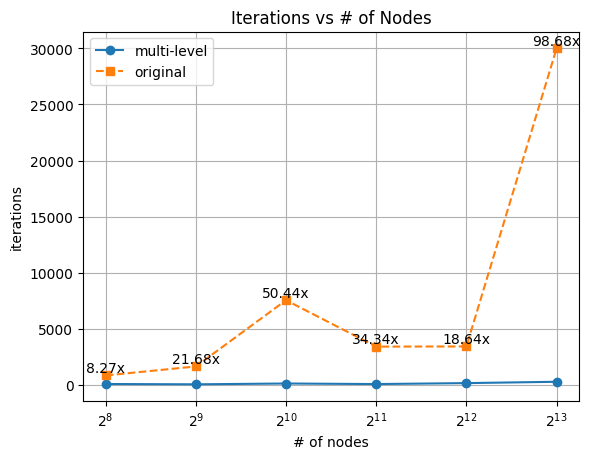

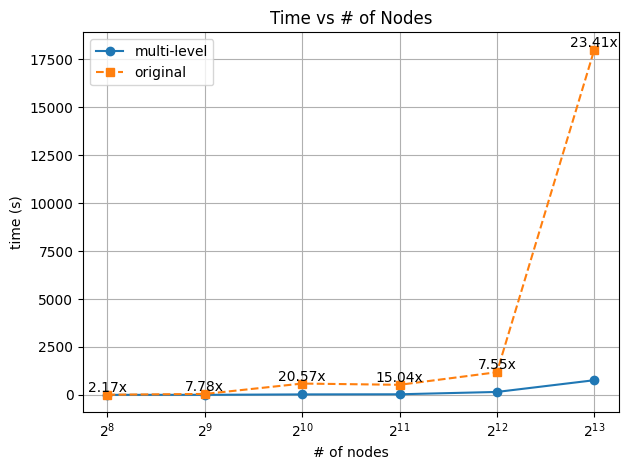

In [ ]:
import matplotlib.pyplot as plt

# Data
nodes = [256, 512, 1024, 2048, 4096, 8196]

iters_multi = [105, 77, 150, 100, 185, 304]
iters_orig  = [868, 1669, 7566, 3434, 3449, 30000]  # lower bound for plot

time_multi = [4.9899821281433105, 6.832485914230347, 28.867820739746094,
              35.16724491119385, 156.85783433914185, 768.7591967582703]
time_orig  = [10.840996980667114, 53.138646364212036, 593.8828203678131,
              528.84259557724, 1184.7146832942963, 18000]  # lower bound for plot

speedup_iters = [o/m for o, m in zip(iters_orig, iters_multi)]
speedup_time  = [o/m for o, m in zip(time_orig, time_multi)]

# Plot 1: iterations vs # of nodes
plt.figure()
plt.plot(nodes, iters_multi, marker='o', label='multi-level')
plt.plot(nodes, iters_orig, marker='s', linestyle='--', label='original')

# Label speedup above BLUE nodes (original curve)
for x, y, s in zip(nodes, iters_orig, speedup_iters):
    plt.text(x, y, f'{s:.2f}x', ha='center', va='bottom')

plt.xlabel('# of nodes')
plt.ylabel('iterations')
plt.title('Iterations vs # of Nodes')
plt.legend()
plt.grid(True)
plt.xscale('log', base=2)

# Plot 2: time vs # of nodes
plt.figure()
plt.plot(nodes, time_multi, marker='o', label='multi-level')
plt.plot(nodes, time_orig, marker='s', linestyle='--', label='original')

# Label speedup above BLUE nodes (original curve)
for x, y, s in zip(nodes, time_orig, speedup_time):
    plt.text(x, y, f'{s:.2f}x', ha='center', va='bottom')

plt.xlabel('# of nodes')
plt.ylabel('time (s)')
plt.title('Time vs # of Nodes')
plt.legend()
plt.grid(True)
plt.xscale('log', base=2)

plt.tight_layout()
plt.show()


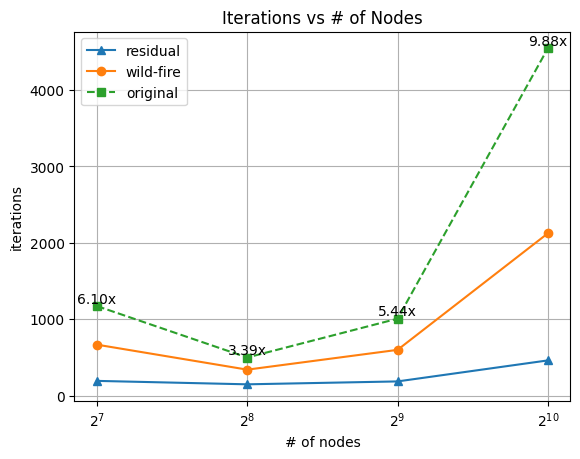

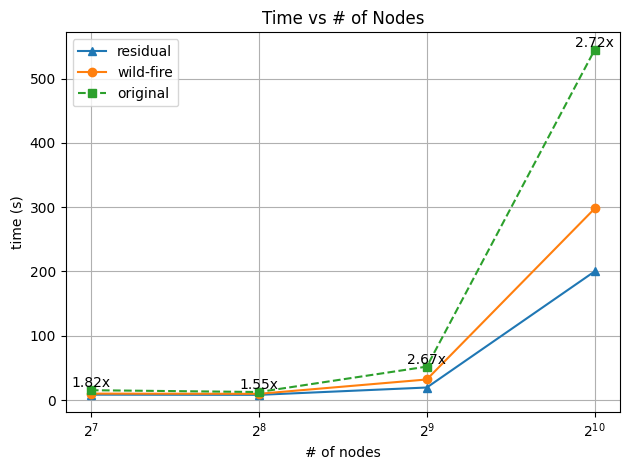

In [103]:
import matplotlib.pyplot as plt

# Data
nodes = [128, 256, 512, 1024]

# original
iters_orig = [1171, 498, 1006, 4544]
time_orig  = [15.3, 12.5, 52.0, 545.0]

# wild-fire
iters_wf = [666, 339, 598, 2123]
time_wf  = [10.0, 9.7, 32.0, 298.0]

# residual
iters_res = [192, 147, 185, 460]
time_res  = [8.4, 8.08, 19.5, 200.2]

# NEW: original / residual speedup
speedup_iters = [o / r for o, r in zip(iters_orig, iters_res)]
speedup_time  = [o / r for o, r in zip(time_orig, time_res)]

# Plot 1: iterations vs # of nodes
plt.figure()
plt.plot(nodes, iters_res, marker='^', linestyle='-',  label='residual')
plt.plot(nodes, iters_wf,  marker='o', linestyle='-',  label='wild-fire')
plt.plot(nodes, iters_orig,marker='s', linestyle='--', label='original')

# 标注 original/residual 倍数（标在 original 节点上）
for x, y, s in zip(nodes, iters_orig, speedup_iters):
    plt.text(x, y, f'{s:.2f}x', ha='center', va='bottom')

plt.xlabel('# of nodes')
plt.ylabel('iterations')
plt.title('Iterations vs # of Nodes')
plt.legend()
plt.grid(True)
plt.xscale('log', base=2)

# Plot 2: time vs # of nodes
plt.figure()
plt.plot(nodes, time_res,  marker='^', linestyle='-',  label='residual')
plt.plot(nodes, time_wf,   marker='o', linestyle='-',  label='wild-fire')
plt.plot(nodes, time_orig, marker='s', linestyle='--', label='original')

for x, y, s in zip(nodes, time_orig, speedup_time):
    plt.text(x, y, f'{s:.2f}x', ha='center', va='bottom')

plt.xlabel('# of nodes')
plt.ylabel('time (s)')
plt.title('Time vs # of Nodes')
plt.legend()
plt.grid(True)
plt.xscale('log', base=2)

plt.tight_layout()
plt.show()


In [ ]:
print("total iteration time: ", 0.1708+0.0386+0.0044+0.0015+0.0002+0.0001+0.0001+0.0018+0.0011+0.0145+0.0444+0.1793)
print("super1: ", 0.1708+0.1793)
print("ratio: ", 0.35009999999999997/0.4568)

print("")
print("total building and backing time: ", 0.0774+0.1253+0.0925+0.4952+0.2424 + 0.0000+0.0003+0.0004+0.0081+0.0121+0.0548)


total iteration time:  0.4568
super1:  0.35009999999999997
ratio:  0.7664185639229422

total building and backing time:  1.1084999999999998


In [ ]:
from copy import deepcopy
aa = deepcopy(layers[1]["graph"])
for i in range(1000):
    aa.synchronous_iteration()

In [ ]:
layers[1]["graph"] = deepcopy(aa)
layers[abs_layer_idx]["graph"], layers[abs_layer_idx]["Bs"], layers[abs_layer_idx]["ks"], layers[abs_layer_idx]["k2s"] = bottom_up_modify_abs_graph(layers[:3])
for i in range(1000):
    layers[-1]["graph"].synchronous_iteration()

bb = deepcopy(layers[-1]["graph"])

In [ ]:
layers[1]["graph"] = deepcopy(aa)
layers[2]["graph"] = deepcopy(bb)


In [ ]:
layers[abs_layer_idx]["graph"], layers[abs_layer_idx]["Bs"], layers[abs_layer_idx]["ks"], layers[abs_layer_idx]["k2s"] = bottom_up_modify_abs_graph(
    layers[:3], eta_damping=0, r_reduced=2)

#layers[abs_layer_idx]["graph"].synchronous_iteration()
print(layers[abs_layer_idx]["graph"].var_nodes[0].mu)
print(bb.var_nodes[0].mu)

[ 44.3736346  104.33323553]
[ 44.3736346  104.33323553]


In [ ]:
layers[abs_layer_idx]["graph"].compute_all_messages()
layers[abs_layer_idx]["graph"].synchronous_iteration()
print(layers[abs_layer_idx]["graph"].var_nodes[0].mu)
bb.synchronous_iteration
print(bb.var_nodes[0].mu)

[ 44.38048663 104.34497706]
[ 44.3736346  104.33323553]


In [ ]:
layers[abs_layer_idx]["graph"], layers[abs_layer_idx]["Bs"], layers[abs_layer_idx]["ks"], layers[abs_layer_idx]["k2s"] = bottom_up_modify_abs_graph(layers[:3])

layers[abs_layer_idx]["graph"].synchronous_iteration()
layers[abs_layer_idx]["graph"].synchronous_iteration()

top_down_modify_super_graph(layers[:3])
top_down_modify_base_and_abs_graph(layers[:2])

energy = energy_map(layers[0]["graph"], include_priors=True, include_factors=True)
print(f"Iter {_+1:03d} | Energy = {energy:.6f}")

Iter 001 | Energy = 2342.435012


In [ ]:
layers[abs_layer_idx]["graph"].var_nodes[0].Sigma

array([[ 3.55637974e+00, -2.08956516e-16],
       [-2.08957089e-16,  3.55637974e+00]])

In [ ]:
bb.var_nodes[0].Sigma

array([[ 3.55637974e+00, -2.08956489e-16],
       [-2.08957608e-16,  3.55637974e+00]])

In [ ]:
layers[1]["graph"].synchronous_iteration()
abs_graph, Bs, ks, k2s = bottom_up_modify_abs_graph(layers[:], eta_damping=0)
layers[2]["graph"] = abs_graph
layers[2]["Bs"], layers[2]["ks"], layers[2]["k2s"] = Bs, ks, k2s

layers[2]["graph"].synchronous_iteration()
layers[2]["graph"].synchronous_iteration()

top_down_modify_super_graph(layers[:3])
layers[1]["graph"].synchronous_iteration()

top_down_modify_base_and_abs_graph(layers[:2])
energy = energy_map(layers[0]["graph"], include_priors=True, include_factors=True)
print(f"Iter {_+1:03d} | Energy = {energy:.6f}")

Iter 001 | Energy = 2328.725297


In [ ]:
for i in range(1):
    for i in range(1, len(layers)):
        name = layers[i]["name"]

        if name.startswith("super1"):
            # Update super using the previous base graph's new linearization points
            pass

        elif name.startswith("super"):
            # Update super using the previous layer's graph
            layers[i]["graph"] = build_super_graph(layers[:i+1], eta_damping=0)

        elif name.startswith("abs"):
            # Rebuild abs using the previous super
            abs_graph, Bs, ks, k2s = bottom_up_modify_abs_graph(layers[:i+1], eta_damping=0)
            layers[i]["graph"] = abs_graph
            layers[i]["Bs"], layers[i]["ks"], layers[i]["k2s"] = Bs, ks, k2s

        # After build, one iteration per layer
        if "graph" in layers[i]:
            layers[i]["graph"].synchronous_iteration()

    # ---- top-down (pass mu) ----
    for i in range(len(layers) - 1, 0, -1):
        # After one iterations per layer, reproject
        if "graph" in layers[i]:
            layers[i]["graph"].synchronous_iteration()

        # this is very important, but dont know why yet
        # so abs layer need more iterations
        #if name.startswith("abs"):
        #    layers[i]["graph"].synchronous_iteration()  

        name = layers[i]["name"]
        if name.startswith("super"):
            # Split super.mu back to base/abs
            top_down_modify_base_and_abs_graph(layers[:i+1])

        elif name.startswith("abs"):
            # Project abs.mu back to super
            top_down_modify_super_graph(layers[:i+1])

    energy = energy_map(layers[0]["graph"], include_priors=True, include_factors=True)
    print(f"Iter {_+1:03d} | Energy = {energy:.6f}")

Iter 001 | Energy = 2328.725279


In [ ]:
layers[1]["graph"] = deepcopy(aa)
layers[abs_layer_idx]["graph"], layers[abs_layer_idx]["Bs"], layers[abs_layer_idx]["ks"], layers[abs_layer_idx]["k2s"] = bottom_up_modify_abs_graph(layers[:3])
for i in range(1):
    layers[-1]["graph"].synchronous_iteration()
    top_down_modify_super_graph(layers[:])
    top_down_modify_base_and_abs_graph(layers[0:2])
    energy = energy_map(layers[0]["graph"], include_priors=True, include_factors=True)
    print(f"Iter {_+1:03d} | Energy = {energy:.6f}")

Iter 1000 | Energy = 2333.057456
Iter 1000 | Energy = 2342.434528
Iter 1000 | Energy = 2346.848939
Iter 1000 | Energy = 2342.829773
Iter 1000 | Energy = 2335.406501
Iter 1000 | Energy = 2329.460781
Iter 1000 | Energy = 2326.647628
Iter 1000 | Energy = 2326.626961
Iter 1000 | Energy = 2328.345039
Iter 1000 | Energy = 2330.722005
Iter 1000 | Energy = 2332.962662
Iter 1000 | Energy = 2334.638546
Iter 1000 | Energy = 2335.631414
Iter 1000 | Energy = 2336.017356
Iter 1000 | Energy = 2335.954211
Iter 1000 | Energy = 2335.604993
Iter 1000 | Energy = 2335.101330
Iter 1000 | Energy = 2334.535153
Iter 1000 | Energy = 2333.964155
Iter 1000 | Energy = 2333.420888
Iter 1000 | Energy = 2332.920827
Iter 1000 | Energy = 2332.468334
Iter 1000 | Energy = 2332.060933
Iter 1000 | Energy = 2331.692470
Iter 1000 | Energy = 2331.355442
Iter 1000 | Energy = 2331.042599
Iter 1000 | Energy = 2330.747874
Iter 1000 | Energy = 2330.466759
Iter 1000 | Energy = 2330.196290
Iter 1000 | Energy = 2329.934812
Iter 1000 

In [ ]:
for i in range(1000):
    layers[abs_layer_idx]["graph"], layers[abs_layer_idx]["Bs"], layers[abs_layer_idx]["ks"], layers[abs_layer_idx]["k2s"] = bottom_up_modify_abs_graph(layers[:3])
    layers[abs_layer_idx]["graph"].synchronous_iteration()
    top_down_modify_super_graph(layers[:])
    top_down_modify_base_and_abs_graph(layers[0:2])
    energy = energy_map(layers[0]["graph"], include_priors=True, include_factors=True)
    print(f"Iter {_+1:03d} | Energy = {energy:.6f}")

Iter 1000 | Energy = 2333.057544
Iter 1000 | Energy = 2339.952725
Iter 1000 | Energy = 2347.586783
Iter 1000 | Energy = 2352.982718
Iter 1000 | Energy = 2357.693991
Iter 1000 | Energy = 2361.411014
Iter 1000 | Energy = 2365.057877
Iter 1000 | Energy = 2368.261650
Iter 1000 | Energy = 2371.582692
Iter 1000 | Energy = 2374.661040
Iter 1000 | Energy = 2377.845726
Iter 1000 | Energy = 2380.855475
Iter 1000 | Energy = 2383.912300
Iter 1000 | Energy = 2386.818810
Iter 1000 | Energy = 2389.717175
Iter 1000 | Energy = 2392.477801
Iter 1000 | Energy = 2395.191398
Iter 1000 | Energy = 2397.777201
Iter 1000 | Energy = 2400.292543
Iter 1000 | Energy = 2402.689672
Iter 1000 | Energy = 2405.004386
Iter 1000 | Energy = 2407.210328
Iter 1000 | Energy = 2409.329563
Iter 1000 | Energy = 2411.349136
Iter 1000 | Energy = 2413.282492
Iter 1000 | Energy = 2415.124784
Iter 1000 | Energy = 2416.884155
Iter 1000 | Energy = 2418.560459
Iter 1000 | Energy = 2420.158657
Iter 1000 | Energy = 2421.681164
Iter 1000 

KeyboardInterrupt: 

In [ ]:
top_down_modify_super_graph(layers[:])
top_down_modify_base_and_abs_graph(layers[0:2])
energy = energy_map(layers[0]["graph"], include_priors=True, include_factors=True)
print(f"Iter {_+1:03d} | Energy = {energy:.6f}")

Iter 531 | Energy = 2335.263449


In [ ]:
layers[1]["graph"].synchronous_iteration()
top_down_modify_base_and_abs_graph(layers[0:2])
energy = energy_map(layers[0]["graph"], include_priors=True, include_factors=True)
print(f"Iter {_+1:03d} | Energy = {energy:.6f}")

Iter 531 | Energy = 2334.490358


In [ ]:
np.linalg.solve(layers[0]["graph"].var_nodes[0].adj_factors[1].adj_beliefs[0].lam, layers[0]["graph"].var_nodes[0].adj_factors[1].adj_beliefs[0].eta)

array([-4.08825805e-09,  7.00557252e-09])

In [ ]:
layers[0]["graph"].var_nodes[0].mu

array([-4.08825829e-09,  7.00557253e-09])

In [ ]:
layers[1]["graph"].var_nodes[0].mu

array([-4.08825799e-09,  7.00557250e-09,  3.94963401e+00, -2.51772335e+01,
        2.59936671e+01, -3.96819499e+01,  3.85359407e+01, -6.20493563e+01,
        1.33215562e+01, -7.12420831e+01])

In [ ]:
layers[0]["graph"].var_nodes[0].mu

array([-4.08825829e-09,  7.00557253e-09])

In [ ]:
compute_energy(layers)

'Energy: 2348.0945'

In [ ]:
(2401-2324)/2324

0.03313253012048193

In [ ]:
2402*(1.03313253)

2481.58433706

In [ ]:
N=6
step=25
prob=0.05
radius=50 
prior_prop=0.02
prior_sigma=1
odom_sigma=1
layers = []
layers = init_layers(N=N, step_size=step, loop_prob=prob, loop_radius=radius, prior_prop=prior_prop, seed=2001)
pair_idx = 0
# Create GBP graph
gbp_graph = build_noisy_pose_graph(layers[0]["nodes"], layers[0]["edges"],
                                    prior_sigma=prior_sigma,
                                    odom_sigma=odom_sigma,
                                    seed=2001)
layers[0]["graph"] = gbp_graph

super_nodes, super_edges, node_map = fuse_to_super_order(layers[0]["nodes"], layers[0]["edges"], k=2, layer_idx=1, tail_heavy=True)
layers.append({"name":f"super{1}", "nodes":super_nodes, "edges":super_edges, "node_map":node_map})
layers[0]["graph"].synchronous_iteration()
layers[1]["graph"] = build_super_graph(layers,eta_damping=0)
supergraph = layers[-1]["graph"]


total = 0
a = layers[0]["graph"].joint_distribution_cov()[0].reshape(layers[0]["graph"].n_var_nodes,2)[:,:]
for i,v in enumerate(layers[0]["graph"].var_nodes[:layers[0]["graph"].n_var_nodes]):
    gt = np.asarray(v.GT[0:2], dtype=float)
    r = np.asarray(a[i][0:2], dtype=float) - gt
    total += 0.5 * float(r.T @ r)
print(total)

abs_nodes, abs_edges = copy_to_abs(layers[1]["nodes"], layers[1]["edges"], 2)

# Ensure super graph has run at least once
#layers[1]["graph"].synchronous_iteration() 
r = 2
layers.append({"name":f"abs{1}", "nodes":abs_nodes, "edges":abs_edges})
layers[2]["graph"], layers[2]["Bs"], layers[2]["ks"], layers[2]["k2s"] = build_abs_graph(layers, r_reduced=r)

vg = VGraph(layers, eta_damping=0)
for i in range(50):
    vg.layers = layers
    vg.layers = vg.vloop()
    layers = vg.layers
    refresh_gbp_results(layers)
    energy = supergraph.energy_map(include_priors=True, include_factors=True)
    print(f"Iter {it+1:03d} | Energy = {energy:.6f}")



6.988972036403319
Iter 1000 | Energy = 7.815849
Iter 1000 | Energy = 6.885167
Iter 1000 | Energy = 6.902868
Iter 1000 | Energy = 6.909297
Iter 1000 | Energy = 6.910688
Iter 1000 | Energy = 6.911066
Iter 1000 | Energy = 6.911152
Iter 1000 | Energy = 6.911174
Iter 1000 | Energy = 6.911179
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6.911181
Iter 1000 | Energy = 6

In [ ]:
from jax import jit
import jax
import jax.numpy as jnp
import time

@jit
def matmul(x, y):
    return x @ y

x = jnp.ones((2000, 8000))
y = jnp.ones((8000, 2000))

# 预热（第一次会 JIT 编译）
_ = matmul(x, y).block_until_ready()

t0 = time.time()
out = matmul(x, y).block_until_ready()
t1 = time.time()

print("Matmul time:", t1 - t0, "seconds")
print("jax devices:", jax.devices())
print("Result device:", out.device)   # ✅ 这里不要加 ()


Matmul time: 0.0009918212890625 seconds
jax devices: [CudaDevice(id=0)]
Result device: cuda:0


In [ ]:
t0 = time.time()
for i in range(100):
    out = matmul(x, y).block_until_ready()
t1 = time.time()


In [ ]:
import numpy as np
x = np.ones((2000, 8000))
y = np.ones((8000, 2000))
t0 = time.time()
for i in range(100):
    out = x@y
t1 = time.time()

In [ ]:
import os
import pathlib
import nvidia.cusparse  # 先把 wheel 里的 cusparse 模块 import 进来

# 找到 pip 安装的 cuSPARSE 动态库所在目录
cusparse_lib_dir = str(pathlib.Path(nvidia.cusparse.__file__).parent)
print("cusparse_lib_dir =", cusparse_lib_dir)

# 把 LD_LIBRARY_PATH 显式设置成这个目录（再附带上原来的其它目录）
old = os.environ.get("LD_LIBRARY_PATH") or ""
os.environ["LD_LIBRARY_PATH"] = cusparse_lib_dir + (":" + old if old else "")
print("LD_LIBRARY_PATH =", os.environ["LD_LIBRARY_PATH"])


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [ ]:
print((6.988972036403319-6.911181)/6.988972036403319)

0.0008997083362999205


In [ ]:
energy = layers[1]["graph"].energy_map(include_priors=True, include_factors=True)
print(f"Iter {it+1:03d} | Energy = {energy:.6f}")

Iter 010 | Energy = 6.911181


In [ ]:
layers[2]["graph"].var_nodes[0].mu

array([ -4.24417217, -24.77807379])